# Analysis of 140k T cells from cancer

In this notebook, we re-analize single-cell TCR/RNA-seq data from [Wu et al. (2020)](https://www.nature.com/articles/s41586-020-2056-8)
generated on the 10x Genomics platform. The original dataset consists of >140k T cells
from 14 treatment-naive patients across four different types of cancer. Roughly 100k of the 140k cells have T-cell receptors. 

## 0. Setup

In [81]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../../scirpy/")
import scirpy as ir
import pandas as pd
import numpy as np
import scanpy as sc
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib
from weblogo.seq import SeqList, unambiguous_protein_alphabet
from weblogo import png_formatter, svg_formatter, eps_formatter
from weblogo import LogoData, LogoOptions, LogoFormat
from IPython.display import Image, display
sc.settings._vector_friendly = True

# whether to run the alignment or use a cached version.
# If `False` and the cached version is not available, will raise an error. 
run_alignment = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook was run with scirpy commit `a73cf2bf46771eaf6072945d94f7a47fc3d80c52` and the following software versions: 

In [82]:
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


In [83]:
def weblogo(seqs, title="", format="png"):
    """Draw a sequence logo from a list of amino acid sequences. """
    logodata = LogoData.from_seqs(SeqList(seqs, alphabet=unambiguous_protein_alphabet))
    logooptions = LogoOptions(logo_title=title)
    logoformat = LogoFormat(logodata, logooptions)
    if format == "png":
        display(Image(png_formatter(logodata, logoformat)))
    elif format == "eps":
        return eps_formatter(logodata, logoformat)

In [84]:
# colors from the paper
colors = {
    "Tumor+NAT expanded": "#9458a2",
    "Tumor singleton": "#ff8000",
    "NAT singleton": "#f7f719",
    "Tumor multiplet": "#eeb3cb",
    "NAT multiplet": "#9cd0de",
    "Blood singleton": "#cce70b",
    "Blood multiplet": "#beac83"
}

## 1. Preparing the data

The dataset ships with the `scirpy` package. We can conveniently load it from the `dataset` module. 

In [85]:
adata = ir.datasets.wu2020()

In [86]:
adata.shape

(141623, 30727)

We only keep the cells with TCR. ~96k cells remain. 

In [87]:
adata = adata[adata.obs["has_tcr"] == "True", :]
adata = adata[~(adata.obs["cluster_orig"] == "nan"), :]

In [88]:
adata.shape

(96067, 30727)

In [89]:
adata.obs.columns

Index(['TRA_1_c_gene', 'TRA_1_cdr3', 'TRA_1_cdr3_nt', 'TRA_1_d_gene',
       'TRA_1_expr', 'TRA_1_j_gene', 'TRA_1_junction_ins', 'TRA_1_v_gene',
       'TRA_2_c_gene', 'TRA_2_cdr3', 'TRA_2_cdr3_nt', 'TRA_2_d_gene',
       'TRA_2_expr', 'TRA_2_j_gene', 'TRA_2_junction_ins', 'TRA_2_v_gene',
       'TRB_1_c_gene', 'TRB_1_cdr3', 'TRB_1_cdr3_nt', 'TRB_1_d_gene',
       'TRB_1_expr', 'TRB_1_j_gene', 'TRB_1_junction_ins', 'TRB_1_v_gene',
       'TRB_2_c_gene', 'TRB_2_cdr3', 'TRB_2_cdr3_nt', 'TRB_2_d_gene',
       'TRB_2_expr', 'TRB_2_j_gene', 'TRB_2_junction_ins', 'TRB_2_v_gene',
       'batch', 'clonotype_orig', 'cluster_orig', 'has_tcr', 'multi_chain',
       'patient', 'sample', 'source'],
      dtype='object')

In [90]:
adata.obs["counts"] = adata.X.sum(axis=1).A1

Trying to set attribute `.obs` of view, copying.


### Preprocess Transcriptomics data

Transcriptomics data needs to be filtered and preprocessed as with any other single-cell dataset.
We recommend following the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
and the best practice paper by [Luecken et al.](https://www.embopress.org/doi/10.15252/msb.20188746). 
For the _Wu et al. (2020)_ dataset, the authors already provide clusters and UMAP coordinates.
Instead of performing clustering and cluster annotation ourselves, we will just use
provided data.

In [91]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=100)

filtered out 13037 genes that are detected in less than 10 cells
filtered out 7 cells that have less than 100 genes expressed


In [92]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [93]:
adata.obsm["X_umap"] = adata.obsm["X_umap_orig"]

In [94]:
mapping = {
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
    "nan": "nan"
}
adata.obs["cluster"] = [mapping[x] for x in adata.obs["cluster_orig"]]

Let's inspect the UMAP plots. The first three panels show the UMAP plot colored by sample, patient and cluster.
We don't observe any clustering of samples or patients that could hint at batch effects.

The lower three panels show the UMAP colored by the T cell markers _CD8_, _CD4_, and _FOXP3_.
We can confirm that the markers correspond to their respective cluster labels.

... storing 'cluster' as categorical


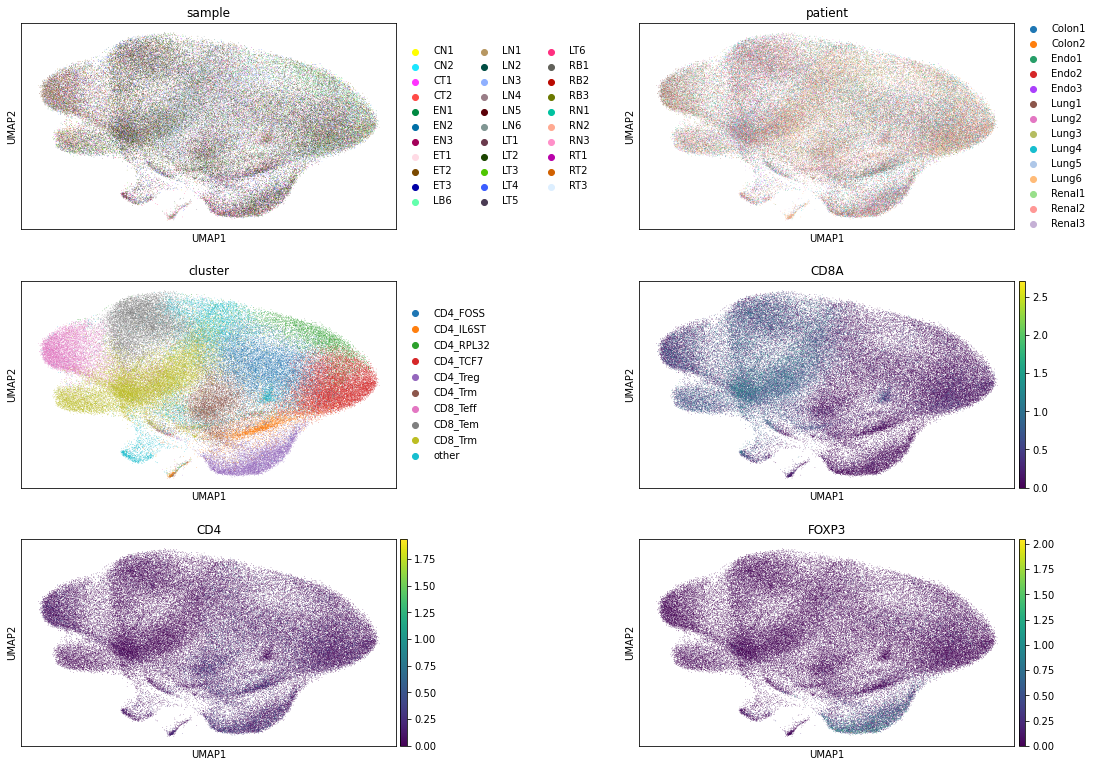

In [95]:
sc.pl.umap(adata, color=["sample", "patient", "cluster", "CD8A", "CD4", "FOXP3"], ncols=2, wspace=.5)

### TCR Quality Control

While most of T cell receptors have exactly one pair of α and β chains, up to one third of 
T cells can have *dual TCRs*, i.e. two pairs of receptors originating from different alleles ([Schuldt et al (2019)](https://doi.org/10.4049/jimmunol.1800904)).

Using the `scirpy.tl.chain_pairing` function, we can add a summary
about the T cell receptor compositions to `adata.obs`.


- *Orphan chain* refers to cells that have either a single alpha or beta receptor chain.
- *Extra chain* refers to cells that have a full alpha/beta receptor pair, and an additional chain.
- *Multichain* refers to cells with more than two receptor pairs detected. These cells are likely doublets.

In [96]:
%%time
ir.tl.chain_pairing(adata)

    Done initalizing
    Done with masks part 1
    Done with masks part 2
CPU times: user 12.8 s, sys: 28.3 ms, total: 12.8 s
Wall time: 12.8 s


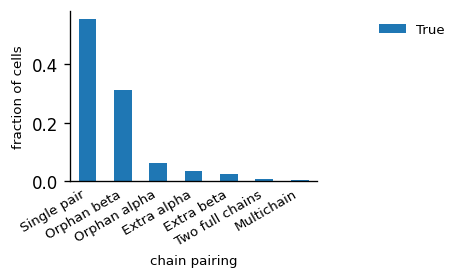

In [97]:
ax = ir.pl.group_abundance(
    adata, groupby="chain_pairing", target_col="has_tcr", fraction="has_tcr"
) 
ax.set_ylabel("fraction of cells")
ax.set_xlabel("chain pairing")
ax.set_title("")
fig = ax.get_figure()
fig.savefig("figures/chain_pairing.svg")

... storing 'chain_pairing' as categorical


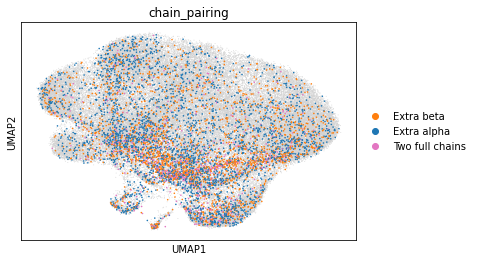

In [98]:
sc.pl.umap(adata,
           color="chain_pairing", 
           groups=["Extra beta", "Extra alpha", "Two full chains"],
           size=[10 if x in ["Extra beta", "Extra alpha", "Two full chains"] else 3 for x in adata.obs["chain_pairing"]])

Indeed, in this dataset, ~7% of cells have more than a one pair of productive T-cell receptors:

In [99]:
print("Fraction of cells with more than one pair of TCRs: {:.2f}".format(
    np.sum(adata.obs["chain_pairing"].isin(["Extra beta", "Extra alpha", "Two full chains"])) / adata.n_obs
))

Fraction of cells with more than one pair of TCRs: 0.07


### Excluding multichain cells
Next, we visualize the _Multichain_ cells on the UMAP plot and exclude them from downstream analysis.
Multichain cells likely represent doublets. This is corroborated by the fact that they tend to 
have a very high number of detected transcripts. 

In [100]:
_, pvalue = sp.stats.mannwhitneyu(adata.obs.loc[adata.obs["multi_chain"] == "True", "counts"].values, adata.obs.loc[adata.obs["multi_chain"] == "False", "counts"].values)

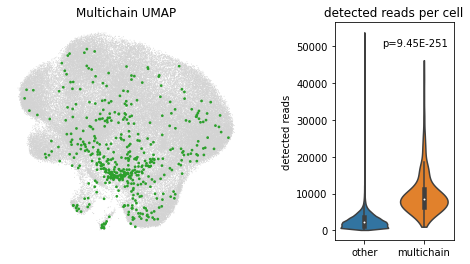

In [101]:
fig, (ax1, ax2) =plt.subplots(1,2, figsize=(8, 4), gridspec_kw={'width_ratios': [2, 1]})
sc.pl.umap(adata, color="chain_pairing", groups="Multichain", size=[30 if x == "Multichain" else 3 for x in adata.obs["chain_pairing"]], ax=ax1, legend_loc="none", show=False, frameon=False, title="Multichain UMAP")
sc.pl.violin(adata, "counts", "multi_chain", ax=ax2, show=False, inner="box", stripplot=False)
ax2.set_ylabel("detected reads")
ax2.set_xlabel("")
ax2.set_xticklabels(["other", "multichain"])
ax2.set_title("detected reads per cell")
ax2.text(.3, 50000, f"p={pvalue:.2E}")
plt.subplots_adjust(wspace=0.5)
fig.savefig("figures/multichains.svg", dpi=600)

In [102]:
adata.shape

(96060, 17690)

In [103]:
adata = adata[adata.obs["chain_pairing"] != "Multichain", :].copy()

In [104]:
adata.shape

(95586, 17690)

## 2. Define clonotypes

Defining clonotypes in `scirpy` is a two-step procedure: 

 1. Computing a neighborhood graph based on CDR3 sequences
 2. Finding connected submodules in the neighborhood graph and annotating them as clonotypes
 
`scirpy` provides several metrics for creating the neighborhood graph. For instance, it is possible to choose between
using nucleotide or amino acid CDR3 sequences, or using a sequence similarity metric based on multiple 
sequence alignments instead of requiring sequences to be identical. 

In [ ]:
sc.settings.verbosity = 4

### identical nucleotide sequences
The authors of the dataset define the clonotypes on the nucleotide sequences and require all sequences of both receptor arms (and multiple chains in case of dual TCRs) to match. 

In [ ]:
%%time
ir.pp.tcr_neighbors(adata, receptor_arms="all", dual_tcr="all", cutoff=0, n_jobs=42, sequence="nt", key_added="tcr_neighbors_nt")

In [ ]:
%%time
ir.tl.define_clonotypes(adata, neighbors_key="tcr_neighbors_nt", key_added="clonotype_nt")

### identical amino acid sequences
Commonly, clonotypes are defined based on their amino acid sequence instead, because they recognize the same epitope. This is the `scirpy` default. 

In [ ]:
%%time
ir.pp.tcr_neighbors(adata, receptor_arms="all", dual_tcr="all", cutoff=0, n_jobs=42)

In [ ]:
%%time
ir.tl.define_clonotypes(adata, neighbors_key="tcr_neighbors", key_added="clonotype")

### similar amino acid sequences

With `scirpy`, it is possible to to one step further and summarize cells into the same clonotype that likely recognize the 
same epitope. This can be done by leveraging levenshtein or alignment distances. Here, we compute the alignment distance
with a cutoff of 15, which is equivalent of three `A`s mutating into `R`. 

In [ ]:
# adata.write_h5ad("./adata_in.h5ad")

In [ ]:
%%time
if run_alignment:
    ir.pp.tcr_neighbors(adata, receptor_arms="all", dual_tcr="all", cutoff=15, key_added="tcr_neighbors_al15")
    adata.write_h5ad("./adata_alignment.h5ad")
else:
    # read cached version
    adata = sc.read_h5ad("./adata_alignment.h5ad")

In [109]:
%%time
ir.tl.define_clonotypes(adata, neighbors_key="tcr_neighbors_al15", key_added="clonotype_alignment")

CPU times: user 1.79 s, sys: 357 ms, total: 2.15 s
Wall time: 2.15 s


### Visualizing clonotype networks
To visualize the network we first call `scirpy.tl.clonotype_network` to compute the layout.
We can then visualize it using `scirpy.pl.clonotype_network`. 

The following plot visualizes all clonotypes with at least 50 cells. Each dot represents a cell, 
and each blob a clonotype. In the left panel each clonotype is labelled, in the right panel 
the clonotypes are colored by patient. 

In [110]:
%%time
ir.tl.clonotype_network(adata, min_size=50, layout="components")

CPU times: user 14.3 s, sys: 307 ms, total: 14.6 s
Wall time: 14.6 s


... storing 'clonotype_alignment' as categorical


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f85edc45310>,
      dtype=object)

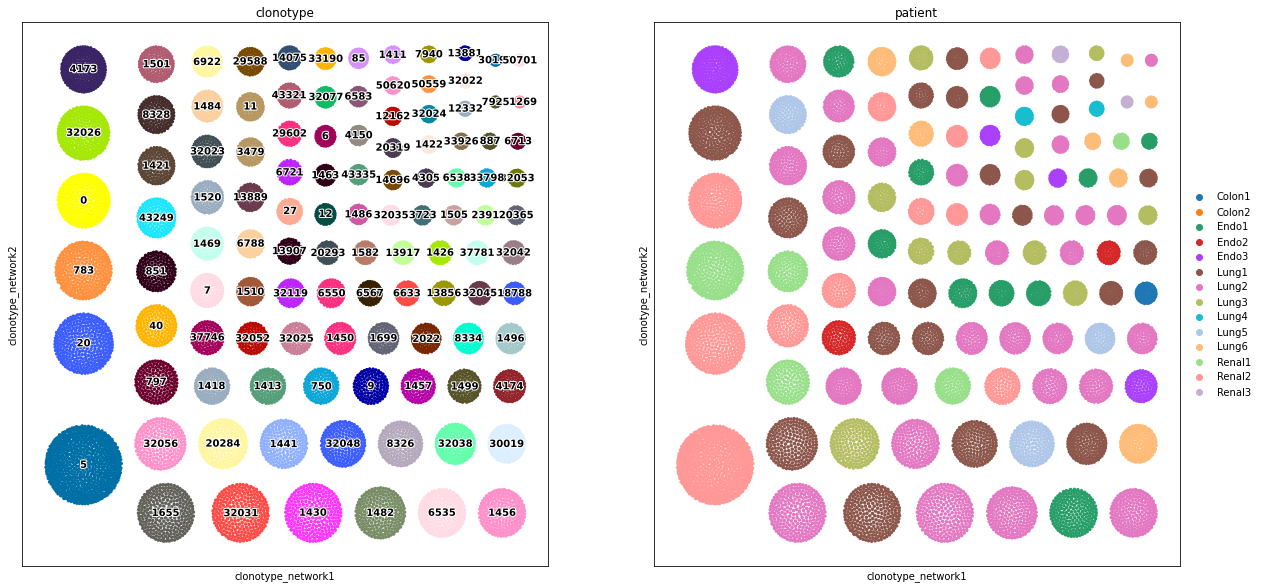

In [111]:
ir.pl.clonotype_network(adata,
                        color=["clonotype", "patient"],
                        edges=False, size=50, ncols=2, 
                        legend_fontoutline=2,
                        legend_loc=["on data", "right margin"])

## 3. Clonotype consistency

Before we dive into the analysis of clonal expansion, we compare the different approaches of clonotype definition. 

### 3.1 nucleotide based (scirpy vs. Wu et al.)
In this section, we compare the clonotypes assigned by `scirpy` assigned to the clonotypes assigned by the authors of the study. 
The original clonotypes are stored in the `clonotype_orig` column of `obs`. 

According to the paper, the clonotypes are defined on nucleotide sequences and require sequence identity of all available chains. 
This should be equivalent of running `scirpy.tcr_neighbors` with `dual_tcr="all"` and `receptor_arms="all"`. 

To assess if the clonotype definitions are equivalent, we first check if there are *clonotypes in `clonotype_orig` that contain multiple clonotypes according to scirpy's definition*. 

In [112]:
# the clonotypes in clonotype_orig that contain multiple clonotype_nt
nt_in_orig = adata.obs.groupby(["clonotype_orig", "clonotype_nt"]).size().reset_index().groupby("clonotype_orig").size().reset_index()
nt_in_orig[nt_in_orig[0] > 1]

Empty DataFrame
Columns: [clonotype_orig, 0]
Index: []

There are none! 

Next, we check if there are *clonotypes in `clonotype_nt` that contain multiple clonotypes according to the authors' definition.*

In [113]:
# the clonotypes in clonotype_nt that contain multiple clonotype_orig
orig_in_nt = adata.obs.groupby(["clonotype_nt", "clonotype_orig"]).size().reset_index().groupby("clonotype_nt").size().reset_index()
with pd.option_context('display.max_rows', 8):
    display(orig_in_nt[orig_in_nt[0] > 1])

clonotype_nt  0
70              70  2
565            565  5
569            569  2
1548          1548  4
...            ... ..
22351        22351  2
25854        25854  2
26240        26240  2
30141        30141  2

[22 rows x 2 columns]

There are a few! 

Let's investigate that further: 

In [114]:
with pd.option_context('display.max_rows', 10):
    display(adata.obs.loc[
        adata.obs["clonotype_nt"].isin(orig_in_nt[orig_in_nt[0] > 1]["clonotype_nt"]),
        ["clonotype_nt", "clonotype_orig", "patient", "TRA_1_cdr3_nt", "TRA_2_cdr3_nt", "TRB_1_cdr3_nt", "TRB_2_cdr3_nt"]
    ].sort_values(["clonotype_nt", "clonotype_orig"]))

clonotype_nt    clonotype_orig patient  \
RT2_ACACCCTAGATATACG-1-0            70    renal2.tnb.C82  Renal2   
RB2_TAAGTGCTCAGTTTGG-1-12           70    renal2.tnb.C82  Renal2   
RN2_TACGGTATCTAACGGT-1-27           70    renal2.tnb.C82  Renal2   
RT3_GAACGGATCGTCTGCT-1-6            70   renal3.tnb.C320  Renal3   
CT1_AGTGGGAAGGTTCCTA-1-13          565    colon1.tn.C372  Colon1   
...                                ...               ...     ...   
LT4_ATAACGCTCTATCCCG-2-17        25854     lung4.tn.C743   Lung4   
ET1_GTTAAGCCACCACGTG-2-16        26240    endo1.tn.C3434   Endo1   
LN6_GGACGTCGTAAGAGGA-1-20        26240   lung6.tnb.C6956   Lung6   
LT6_AGCGTATGTAGAGCTG-1-18        30141    lung6.tnb.C829   Lung6   
RN2_TGGCTGGAGCTAGTCT-1-27        30141  renal2.tnb.C3707  Renal2   

                                                        TRA_1_cdr3_nt  \
RT2_ACACCCTAGATATACG-1-0         TGTGCTGTGAGAGATCGCGACTACAAGCTCAGCTTT   
RB2_TAAGTGCTCAGTTTGG-1-12        TGTGCTGTGAGAGATCGCGACTACAAGCTCAGCTTT   
RN2_TACGGTATCTAACGGT-1-27        TGTGCTGTGAGAGATCGCGACTACAAGCTCAGCTTT   
RT3_GAACGGATCGTCTGCT-1-6         TGTGCTGTGAGAGATCGCGACTACAAGCTCAGCTTT   
CT1_AGTGGGAAGGTTCCTA-1-13        TGTGCTGTGATGGATAGCAACTATCAGTTAATCTGG   
...                                                               ...   
LT4_ATAACGCTCTATCCCG-2-17  TGTGCTGTGAGTGGTACCGGCACTGCCAGTAAACTCACCTTT   
ET1_GTTAAGCCACCACGTG-2-16                                        None   
LN6_GGACGTCGTAAGAGGA-1-20                                        None   
LT6_AGCGTATGTAGAGCTG-1-18                                        None   
RN2_TGGCTGGAGCTAGTCT-1-27                                        None   

                          TRA_2_cdr3_nt  \
RT2_ACACCCTAGATATACG-1-0           None   
RB2_TAAGTGCTCAGTTTGG-1-12          None   
RN2_TACGGTATCTAACGGT-1-27          None   
RT3_GAACGGATCGTCTGCT-1-6           None   
CT1_AGTGGGAAGGTTCCTA-1-13          None   
...                                 ...   
LT4_ATAACGCTCTATCCCG-2-17          None   
ET1_GTTAAGCCACCACGTG-2-16          None   
LN6_GGACGTCGTAAGAGGA-1-20          None   
LT6_AGCGTATGTAGAGCTG-1-18          None   
RN2_TGGCTGGAGCTAGTCT-1-27          None   

                                                     TRB_1_cdr3_nt  \
RT2_ACACCCTAGATATACG-1-0                                      None   
RB2_TAAGTGCTCAGTTTGG-1-12                                     None   
RN2_TACGGTATCTAACGGT-1-27                                     None   
RT3_GAACGGATCGTCTGCT-1-6                                      None   
CT1_AGTGGGAAGGTTCCTA-1-13                                     None   
...                                                            ...   
LT4_ATAACGCTCTATCCCG-2-17                                     None   
ET1_GTTAAGCCACCACGTG-2-16  TGTGCCAGCAGCTTAGTTGGGGCCAACGTCCTGACTTTC   
LN6_GGACGTCGTAAGAGGA-1-20  TGTGCCAGCAGCTTAGTTGGGGCCAACGTCCTGACTTTC   
LT6_AGCGTATGTAGAGCTG-1-18     TGTGCCAGCTCACCACAACAAGAGACCCAGTACTTC   
RN2_TGGCTGGAGCTAGTCT-1-27     TGTGCCAGCTCACCACAACAAGAGACCCAGTACTTC   

                          TRB_2_cdr3_nt  
RT2_ACACCCTAGATATACG-1-0           None  
RB2_TAAGTGCTCAGTTTGG-1-12          None  
RN2_TACGGTATCTAACGGT-1-27          None  
RT3_GAACGGATCGTCTGCT-1-6           None  
CT1_AGTGGGAAGGTTCCTA-1-13          None  
...                                 ...  
LT4_ATAACGCTCTATCCCG-2-17          None  
ET1_GTTAAGCCACCACGTG-2-16          None  
LN6_GGACGTCGTAAGAGGA-1-20          None  
LT6_AGCGTATGTAGAGCTG-1-18          None  
RN2_TGGCTGGAGCTAGTCT-1-27          None  

[102 rows x 7 columns]

All cells of the same `clonotype_nt` have the same nucleotide sequences (apart from swapping between `TRA_1` and `TRA_2` or `TRB_1` and `TRB_2`, respectively). Our method appears to work as expected. 
The inconsistencies seem to arise from the fact that the clonotypes have the same sequences, but originate from different patients. Apparently, the 
authors did not allow clonotypes from different patients (which makes sense when approaching clonotypes from a genomic point of view, not from an epitope recognition point of view). 

When checking the number of clonotypes_orig per clonotype_nt and patient, we eradicate the differences: 

In [115]:
# the clonotypes in clonotype_nt that contain multiple clonotype_orig
orig_in_nt = adata.obs.groupby(["clonotype_nt", "patient", "clonotype_orig"]).size().reset_index().groupby(["clonotype_nt", "patient"]).size().reset_index()
with pd.option_context('display.max_rows', 8):
    display(orig_in_nt[orig_in_nt[0] > 1])

Empty DataFrame
Columns: [clonotype_nt, patient, 0]
Index: []

Now, also the number of clonotypes is consistent:

In [116]:
assert adata.obs["clonotype_orig"].unique().size == adata.obs.groupby(["patient", "clonotype_nt"]).size().reset_index().shape[0]
print(f"""Number of clonotypes according to Wu et al.: {adata.obs["clonotype_orig"].unique().size}""")
print(f"""Number of clonotypes according to scirpy: {adata.obs.groupby(["clonotype_nt"]).size().reset_index().shape[0]}""")
print(f"""Number of clonotypes according to scirpy, within patient: {adata.obs.groupby(["patient", "clonotype_nt"]).size().reset_index().shape[0]}""")

Number of clonotypes according to Wu et al.: 54751
Number of clonotypes according to scirpy: 54719
Number of clonotypes according to scirpy, within patient: 54751


### 3.2 amino-acid vs. nucleotide-based

For a few clonotypes, we observe differences comparing the amino-accid vs. nucleotide-based approach for defining clonotypes. 
Clonotypes with the same amino acid sequence but different nucleotide sequences recognize the same antigen - 
but derive from different antedescent cells. This can be an example of convergent evolution. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8617191e50>,
      dtype=object)

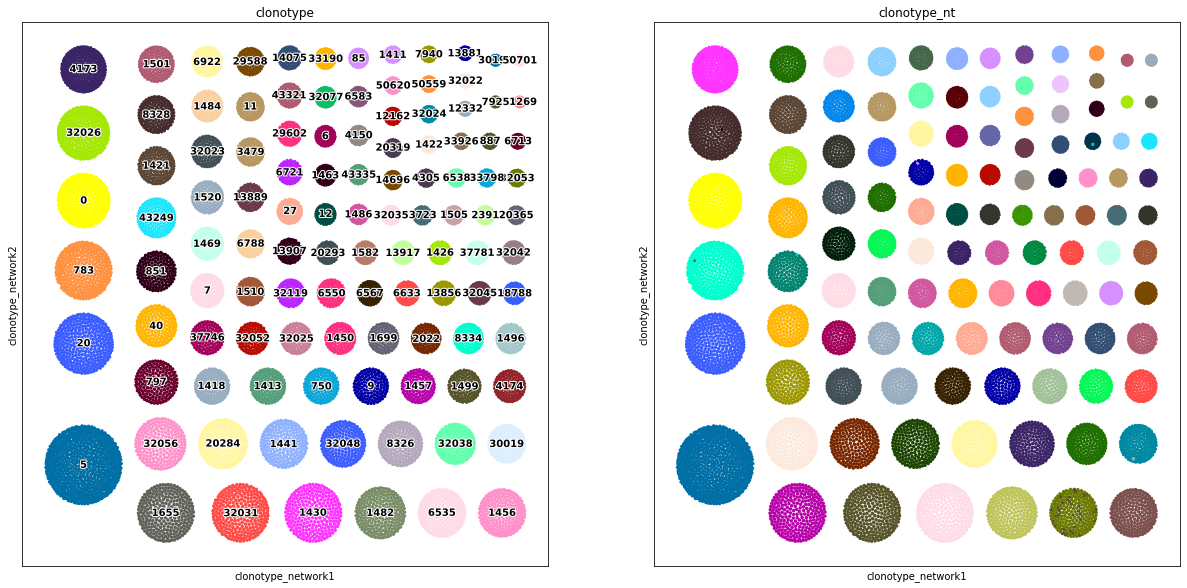

In [117]:
ir.pl.clonotype_network(adata,
                        color=["clonotype", "clonotype_nt"],
                        edges=False, size=50, ncols=2, 
                        legend_fontoutline=2,
                        legend_loc=["on data", "none"])

Let's find the cells that belong to clonotypes that have different nucleotide sequences but the same amino acid sequences: 

In [118]:
nt_in_aa = adata.obs.groupby(["clonotype_nt", "clonotype"]).size().reset_index().groupby(["clonotype"]).size().reset_index()
convergent_clonotypes = nt_in_aa.loc[nt_in_aa[0] > 1, "clonotype"]

In [119]:
adata.obs["is_convergent"] = ["convergent" if x else "-" for x in adata.obs["clonotype"].isin(convergent_clonotypes)]

... storing 'is_convergent' as categorical


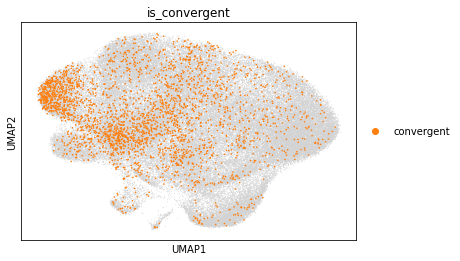

In [120]:
sc.pl.umap(adata, color="is_convergent", groups=["convergent"], size=[10 if x == "convergent" else 3 for x in adata.obs["is_convergent"]])

The phonomenon appears to primarily occur in CD8+ effector and tissue resident T cells: 

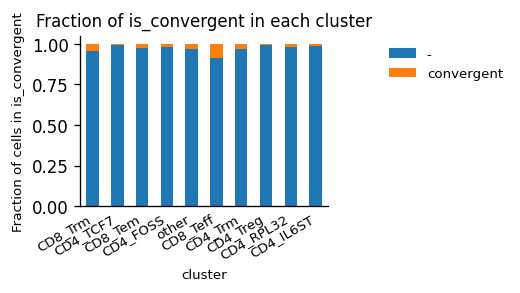

In [121]:
ir.pl.group_abundance(adata, groupby="cluster", target_col="is_convergent", fraction=True)

### 3.3 amino-acid identity vs. alignment distance
When computing the alignment distance, we allowed a distance of `15`, based on the BLOSUM62 matrix. 
This is eqivalent of three `A`s mutating into `R`. 

The alignment distance allows us to identify similar CDR3 sequences, that likely recognize the same epitope. 

For the following visualization, we exclude cells with *Orphan* chains. Having only one chain that 
needs to match there tend to be a lot of similar cells within a distance of `15` resulting in 
large, uninformative networks for those cells. 

In [122]:
%%time
adata_sub = adata[~adata.obs["chain_pairing"].str.startswith("Orphan"), :]

CPU times: user 1min 10s, sys: 127 ms, total: 1min 10s
Wall time: 1min 10s


In [123]:
%%time
ir.tl.clonotype_network(adata_sub, min_size=50, layout="components", neighbors_key="tcr_neighbors_al15", key_clonotype_size="clonotype_alignment_size")

CPU times: user 12.1 s, sys: 624 ms, total: 12.8 s
Wall time: 12.8 s


We'll have a closer look at the following clonotypes, as they seem interesting: 

In [124]:
selected_clonotypes = ["10411", "5304", "1626", "632"]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8613d79550>],
      dtype=object)

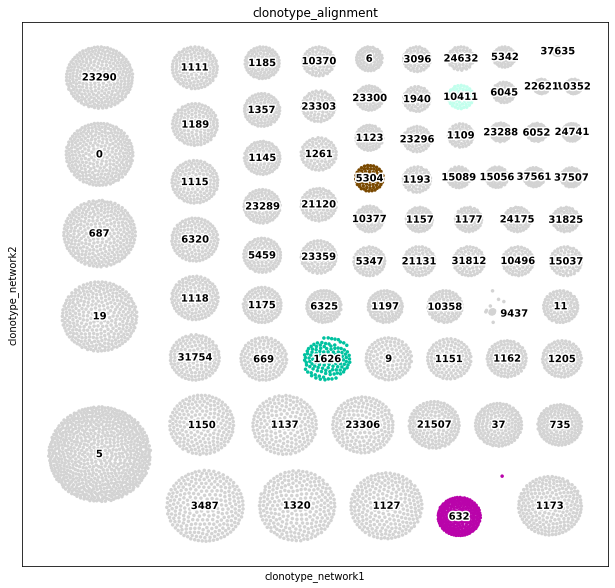

In [125]:
ir.pl.clonotype_network(adata_sub, color=["clonotype_alignment"], groups=selected_clonotypes, edges=False, size=50, ncols=2, legend_loc="on data", legend_fontoutline=3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f860e271c90>,
      dtype=object)

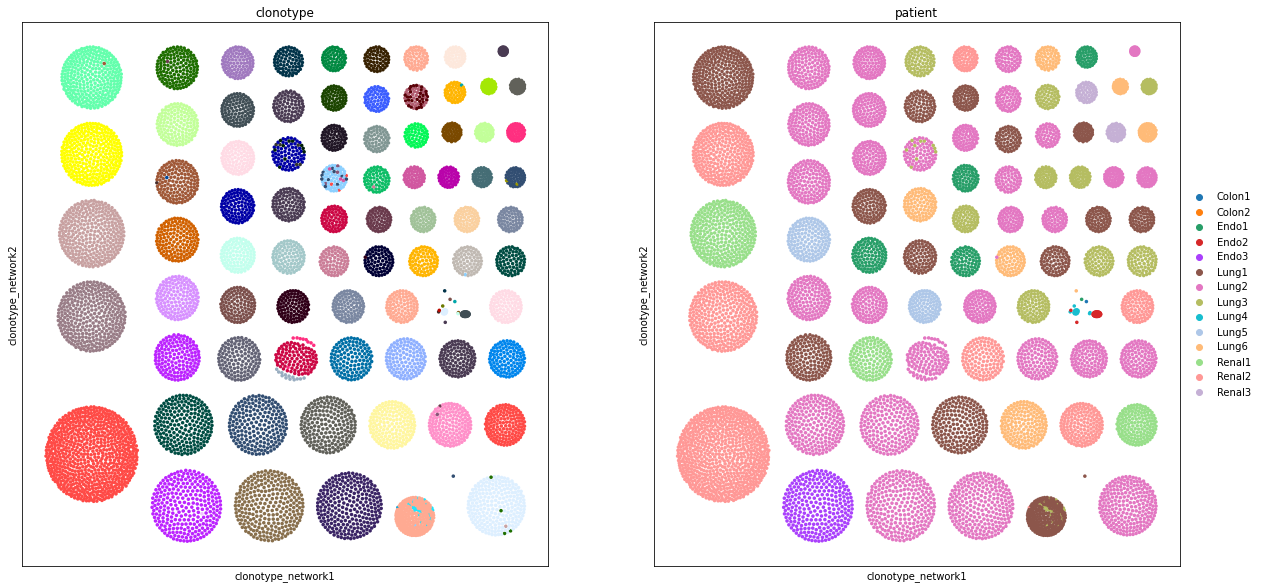

In [126]:
ir.pl.clonotype_network(adata_sub, color=["clonotype", "patient"], edges=False, size=50, ncols=2, legend_loc=["none", "right margin"], legend_fontoutline=2)

In [127]:
%%capture
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ir.pl.clonotype_network(adata_sub, color="clonotype", edges=False, size=50, legend_loc="none", ax=ax, frameon=False)
ax.set_title("clonotypes")
fig.savefig("figures/clonotype_network.svg")

The patient distribution of the four clonotypes: 

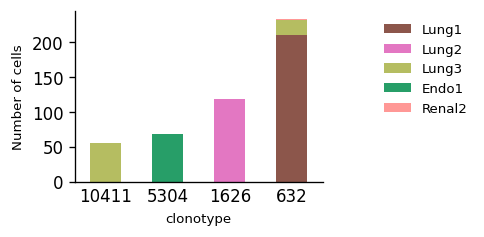

In [128]:
ax = ir.pl.group_abundance(adata_sub[adata_sub.obs["clonotype_alignment"].isin(selected_clonotypes), :], groupby="clonotype_alignment", sort=selected_clonotypes, target_col="patient")
ax.xaxis.set_tick_params(rotation=0)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("center")
ax.tick_params(labelsize=10)
fig = ax.get_figure()
ax.set_title("")
ax.set_xlabel("clonotype")
fig.savefig("figures/clonotype_network_patients.svg")

#### Sequence logos

In [129]:
for ct in selected_clonotypes:
    for chain, chain_label in zip(["TRA_1_cdr3", "TRB_1_cdr3"], ["alpha", "beta"]):
        with open(f"figures/logo_ct_{ct}_{chain_label}.eps", 'wb') as f:
            f.write(weblogo(adata.obs.loc[adata.obs["clonotype_alignment"] == ct, chain].values, title=f"clonotype {ct}: {chain_label}-chain", format="eps"))

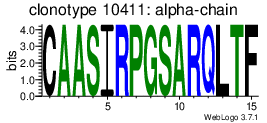

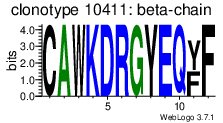

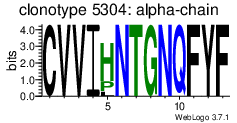

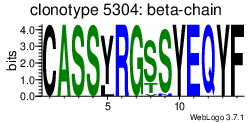

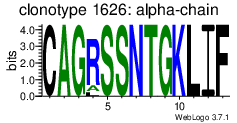

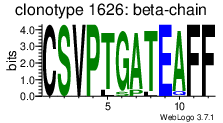

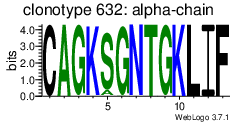

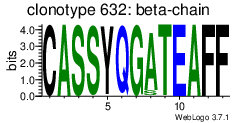

In [130]:
for ct in selected_clonotypes:
    for chain, chain_label in zip(["TRA_1_cdr3", "TRB_1_cdr3"], ["alpha", "beta"]):
        weblogo(adata.obs.loc[adata.obs["clonotype_alignment"] == ct, chain].values, title=f"clonotype {ct}: {chain_label}-chain", format="png")

Clonotype `632` could is shared among multiple patients and could be specific for a common, viral antigen. 

In case of the clonotype `1261` epitope (which we didin't highlight above) we find evidence in *vdjdb* that it could be specific for an Human Cytomegalievirus (CMV) antigen:
 * In [vdjdb](https://vdjdb.cdr3.net/search), we find a CMV-specific alpha-chain searching with the `CAV[STR][LG]QAGTALIF` pattern. 
 * Searching for the beta-chain pattern does not yield a direct result. However, allowing up to two substitutions, we find a CMV-specific chain as well. 

#### convergent clonotypes
We define a clonotype as being convergent, if there are different versions of nucleotide sequences for similar clonotypes, within the same patient.

We define convergence
 * on the level of amino-acid identity vs nucleotide identity
 * on the level of amino-acid similarity vs nucleotide identity


In [131]:
convergent_aa = adata.obs.groupby(["clonotype", "clonotype_alignment", "patient"]).size().reset_index().groupby(["clonotype_alignment", "patient"]).size().reset_index()
convergent_nt = adata.obs.groupby(["clonotype_nt", "clonotype_alignment", "patient"]).size().reset_index().groupby(["clonotype_alignment", "patient"]).size().reset_index()
convergent_clonotypes_aa = convergent_aa.loc[convergent_aa[0] > 1, "clonotype_alignment"].values
convergent_clonotypes_nt = convergent_nt.loc[convergent_nt[0] > 1, "clonotype_alignment"].values

In [132]:
# convergent clonotypes, AA identity vs alignment
adata.obs["convergent_aa"] = [str(x) for x in adata.obs["clonotype_alignment"].isin(convergent_clonotypes_aa) & ~adata.obs["chain_pairing"].str.startswith("Orphan")]
# convergent clonotypes, NN identity vs AA alignment
adata.obs["convergent_nt"] = [str(x) for x in adata.obs["clonotype_alignment"].isin(convergent_clonotypes_nt) & ~adata.obs["chain_pairing"].str.startswith("Orphan")]

... storing 'convergent_aa' as categorical
... storing 'convergent_nt' as categorical


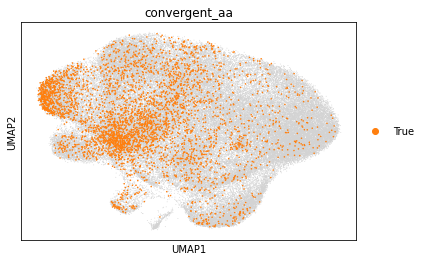

In [133]:
sc.pl.umap(adata, color=["convergent_aa"], groups="True", size=[10 if x == "True" else 3 for x in adata.obs["convergent_aa"]])

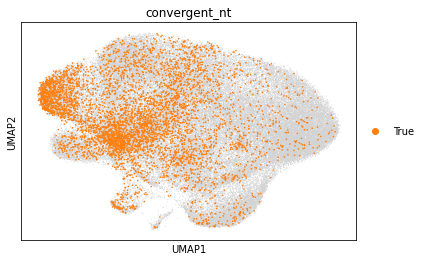

In [134]:
sc.pl.umap(adata, color=["convergent_nt"], groups="True", size=[10 if x == "True" else 3 for x in adata.obs["convergent_nt"]])

In [135]:
%%capture
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sc.pl.umap(adata, color=["convergent_nt"], groups="True", size=[10 if x == "True" else 3 for x in adata.obs["convergent_nt"]], ax=ax, frameon=False, legend_loc="none", show=False)
ax.set_title("convergent clonotypes")
fig.savefig('figures/convergent_clonotypes_umap.svg')

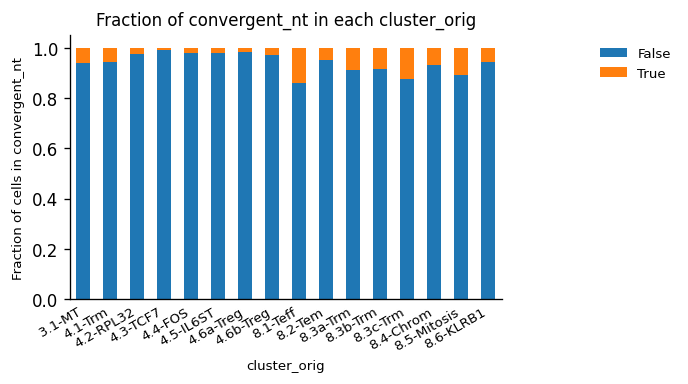

In [138]:
ir.pl.group_abundance(adata, groupby="cluster_orig", target_col="convergent_nt", fraction=True, sort="alphabetical", fig_kws={"dpi": 120})

#### Inspecting only converged clonotypes

In [139]:
adata_converged = adata[(adata.obs["convergent_nt"] == "True") & ~adata.obs["chain_pairing"].str.startswith("Orphan"), :]

In [140]:
%%time
ir.tl.clonotype_network(adata_converged, min_size=1, layout="components", neighbors_key="tcr_neighbors_al15", key_clonotype_size="clonotype_alignment_size")

CPU times: user 3.71 s, sys: 30.8 ms, total: 3.74 s
Wall time: 3.74 s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f860e42b8d0>,
      dtype=object)

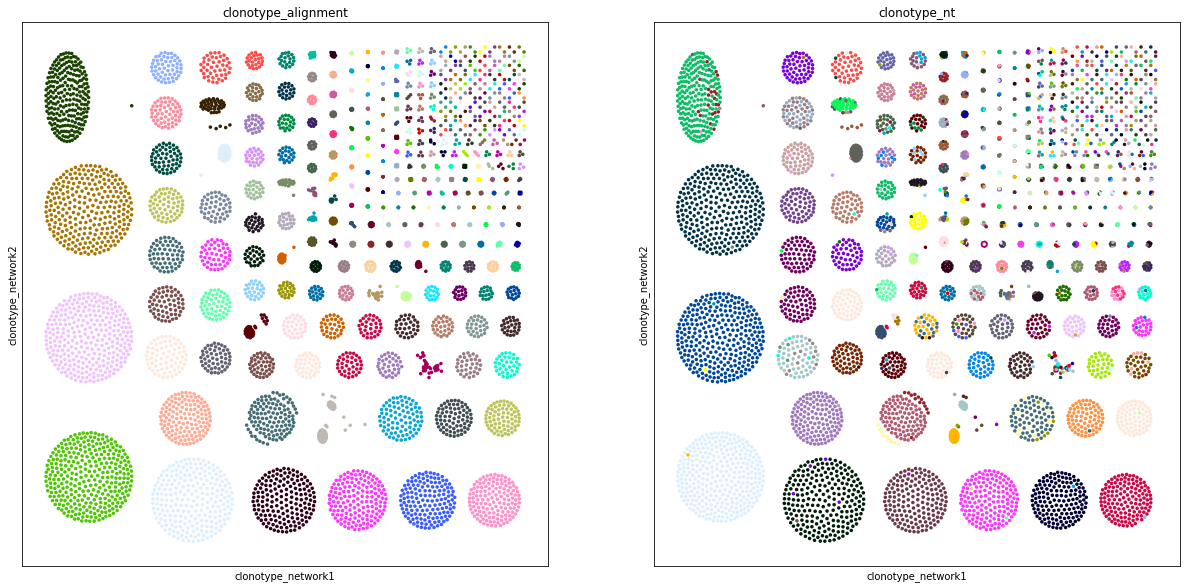

In [141]:
ir.pl.clonotype_network(adata_converged, color=["clonotype_alignment", "clonotype_nt"], edges=False, size=50, ncols=2, legend_loc=["none", "none"], legend_fontoutline=2)

## 4. Clonal expansion
In this section, we assess the clonal expansion

 - across patients
 - across clusters
 - across tissue sources
 
With the `pl.clonal_expansion` function, we can easily visualize the clonal expansion
by different variables. Per default, the plot shows the fraction of
cells belonging to an expanded clonotype. 

### clonal expansion across patients

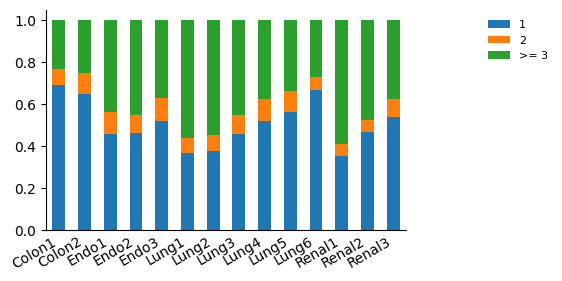

In [142]:
fig, ax = plt.subplots(dpi=100)
ir.pl.clonal_expansion(adata, groupby="patient", summarize_by="cell", show_nonexpanded=True, ax=ax)
ax.tick_params(labelsize=10)
fig.savefig("figures/expansion_patients_cell.svg")

Alternatively, we can show the *fraction of expanded clonotypes*. 

/home/sturm/.conda/envs/scirpy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


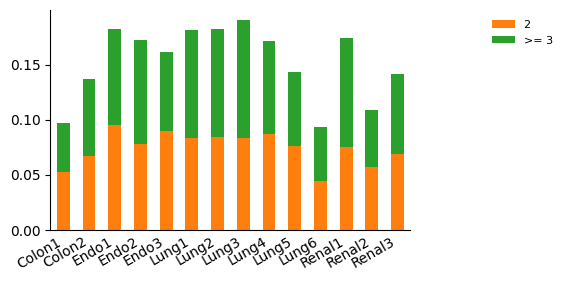

In [143]:
fig, ax = plt.subplots(dpi=100)
ir.pl.clonal_expansion(adata, groupby="patient", summarize_by="clonotype", show_nonexpanded=False, colors=["#FF7F0E", "#2CA02C"], ax=ax)
ax.tick_params(labelsize=10)
fig.savefig("figures/expansion_patients_clonotype.svg")

In the paper, the authors state that depending on the patient, between 9 and 18% of clonotypes
are expanded. Our results are highly consistent with these results: 

In [144]:
fraction_expanded = ir.tl.summarize_clonal_expansion(adata, groupby="patient", summarize_by="clonotype", normalize=True).drop("1", axis="columns").sum(axis=1)

In [145]:
print(f"Between {min(fraction_expanded):.1%} and {max(fraction_expanded):.1%} of clonotypes are expanded.")

Between 9.3% and 19.0% of clonotypes are expanded.


### clonal expansion across cell-type clusters
We observe that clonal expansion is highest among the CD8+ T-cell clusters, in particular effector and tissue-resident T cells. 

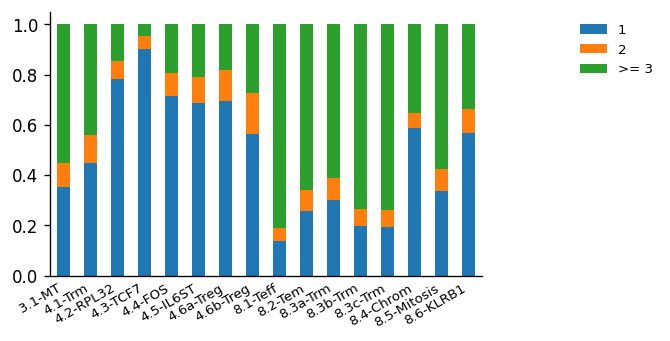

In [146]:
ir.pl.clonal_expansion(adata, groupby="cluster_orig", summarize_by="cell", show_nonexpanded=True, fig_kws={"dpi": 120})

### clonal expansion across tissue sources
The fraction of expanded cell is roughly equivalent among tumor and ajacent normal tissue, but lower in 
blood. 

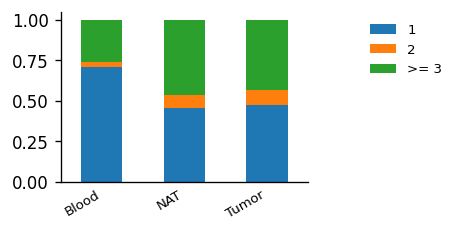

In [147]:
ir.pl.clonal_expansion(adata, groupby="source", summarize_by="cell", show_nonexpanded=True)

## 5. Dual- and blood expanded clonotypes
Finally, we will divide the clonotypes into different categories, based on their expansion in blood, tissue and tumor samples. 

In particular, we will
 * identify *dual-expanded* clonotypes, which are expanded in both adjacent tissue and tumor samples
 * identify blood-expanded clonotypes

and compare their abundance across cell-types and patients. 

For an illustration, please refer to Fig. 1b of the *Wu et al. (2020)* paper. 

In [148]:
clonotype_size_by_source = adata.obs.groupby(["patient", "source", "clonotype"], observed=True).size().reset_index(name="clonotype_count_by_source")
adata.obs = adata.obs.reset_index().merge(clonotype_size_by_source, how="left").set_index('index')

In [149]:
blood_expanded = []
for is_expanded, source in zip((adata.obs["source"] == "Blood") & (adata.obs["clonotype_count_by_source"] > 1), adata.obs["source"]):
    if source == "Blood":
        if is_expanded:
            blood_expanded.append("expanded")
        else:
            blood_expanded.append("not expanded")
    else:
        blood_expanded.append("independent")

In [150]:
adata.obs["blood_expanded"] = blood_expanded

In [151]:
clonotype_membership = {ct: list() for ct in adata.obs["clonotype"]}
for clonotype, source in zip(adata.obs["clonotype"], adata.obs["source"]):
    clonotype_membership[clonotype].append(source)
clonotype_membership = {ct: set(sources) for ct, sources in clonotype_membership.items()}

In [152]:
expansion_category = []
for clonotype, clonotype_size, source in zip(adata.obs["clonotype"], adata.obs["clonotype_size"], adata.obs["source"]):
    if clonotype_size == 1:
        if source == "Blood":
            expansion_category.append("Blood singleton")
        elif source == "NAT":
            expansion_category.append("NAT singleton")
        elif source == "Tumor":
            expansion_category.append("Tumor singleton")
    elif clonotype_size >1:
        membership = clonotype_membership[clonotype]
        if "Tumor" in membership and "NAT" in membership:
            expansion_category.append("Tumor+NAT expanded")
        elif "Tumor"in membership:
            expansion_category.append("Tumor multiplet")
        elif "NAT" in membership:
            expansion_category.append("NAT multiplet")
        elif "Blood" in membership:
            # these are *only* expanded in blood
            expansion_category.append("Blood multiplet")
            
assert len(expansion_category) == adata.n_obs       

In [153]:
adata.obs["cell_type"] = adata.obs["cluster_orig"].str[0]
adata.obs["tumor_type"] = adata.obs["patient"].str[:-1]

In [154]:
adata.obs["expansion_category"] = expansion_category

In [155]:
# make categorical and store colors
adata._sanitize()
adata.uns["expansion_category_colors"] = [colors[x] for x in adata.obs["expansion_category"].cat.categories]

... storing 'blood_expanded' as categorical
... storing 'cell_type' as categorical
... storing 'tumor_type' as categorical
... storing 'expansion_category' as categorical


Mostly CD8+ effector and tissue-resident T cells are blood-expanded and dual-expanded: 

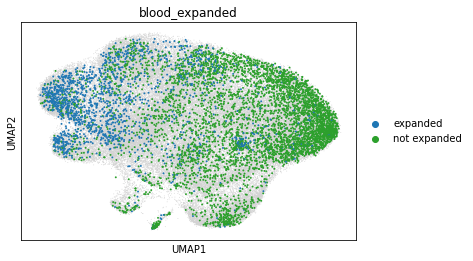

In [156]:
sc.pl.umap(adata, color="blood_expanded", groups=["expanded", "not expanded"], size=[15 if x in ["expanded", "not expanded"] else 3 for x in adata.obs["blood_expanded"]])

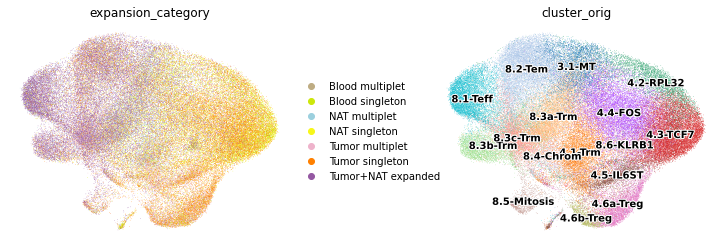

In [157]:
ir.pl.embedding(adata, basis="umap", color=["expansion_category", "cluster_orig"], legend_loc=["right margin", "on data"], show=True, legend_fontoutline=2, frameon=False, wspace=.5, panel_size=(6, 4))

In [158]:
%%capture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 4), dpi=300)
sc.pl.umap(adata, color="expansion_category", legend_loc="none", show=False, ax=ax1, frameon=False)
sc.pl.umap(adata, color="cluster_orig", legend_loc="on data", show=False, ax=ax2, legend_fontoutline=2, frameon=False)
ax1.set_title("clonal expansion pattern")
ax2.set_title("cell-type cluster")
plt.subplots_adjust(wspace=.1)
fig.savefig("figures/clonal_expansion_umap.svg")

In [159]:
%%capture
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sc.pl.umap(adata, color="cluster_orig", legend_loc="none", show=False, ax=ax, legend_fontoutline=2, frameon=False)
ax.set_title("")
fig.savefig("figures/cluster_orig.png")

Categories by cell type (fractions and count):

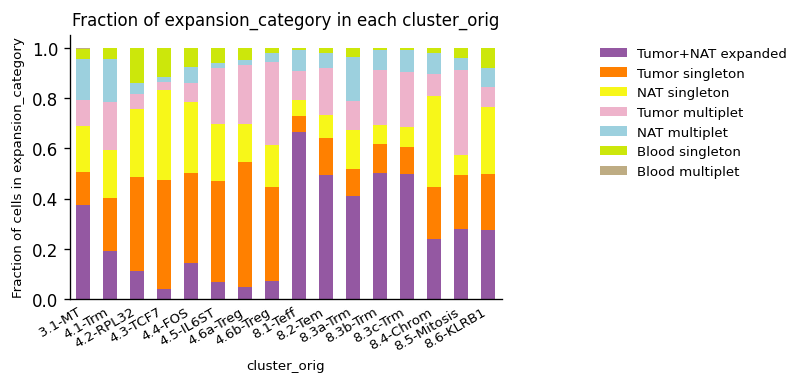

In [160]:
ir.pl.group_abundance(
    adata, groupby="cluster_orig", target_col="expansion_category", fraction=True, fig_kws={"dpi": 120}, sort="alphabetical"
)

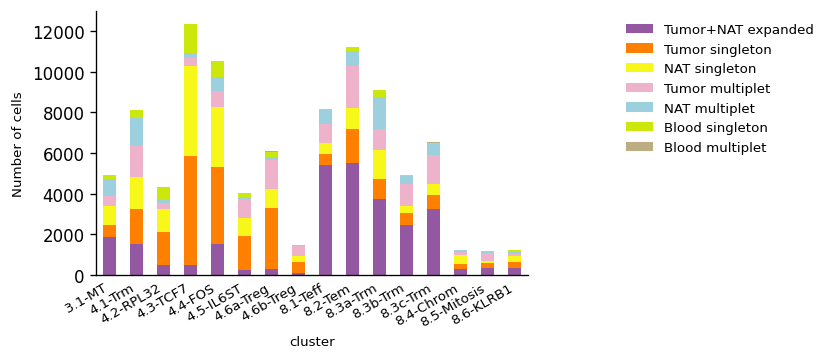

In [161]:
fig, ax = plt.subplots(dpi=120)
ir.pl.group_abundance(
    adata, groupby="cluster_orig", target_col="expansion_category", fraction=False, ax=ax, sort="alphabetical"
)
ax.set_title("")
ax.set_xlabel("cluster")
fig.savefig("figures/expansion_category_cluster.svg")

Categories by tumor type:

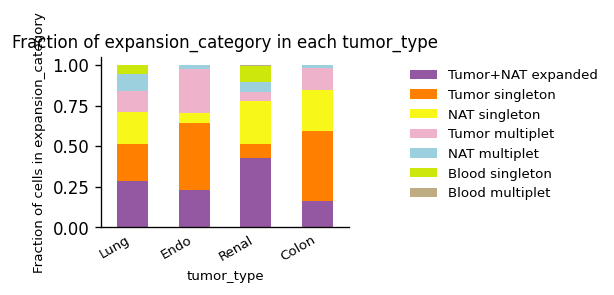

In [162]:
ir.pl.group_abundance(
    adata, groupby="tumor_type", target_col="expansion_category", fraction=True
)

The fraction of blood-expanded, blood non-expanded and blood-independent cells 
for the four patients with blood samples

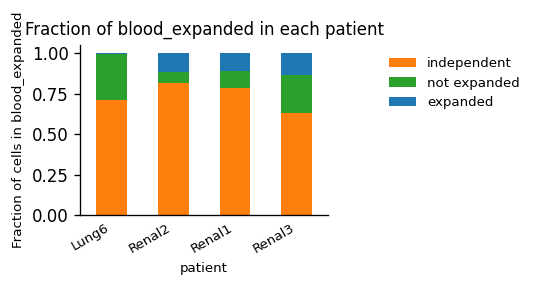

In [163]:
ir.pl.group_abundance(
    adata[adata.obs["patient"].isin(["Lung6", "Renal1", "Renal2", "Renal3"]), :],
    groupby="patient",
    target_col="blood_expanded",
    fraction=True
)

Tissue infiltration patterns. The bar plots show the distribution of cells by tissue expansion patterns from 
blood-indpendned, non-expanded and expanded clones. 

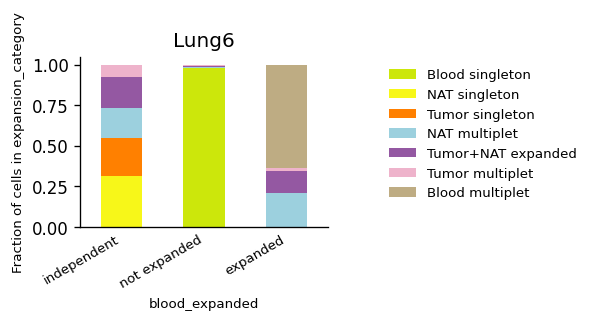

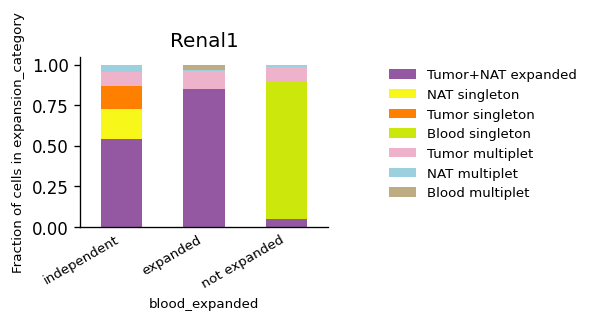

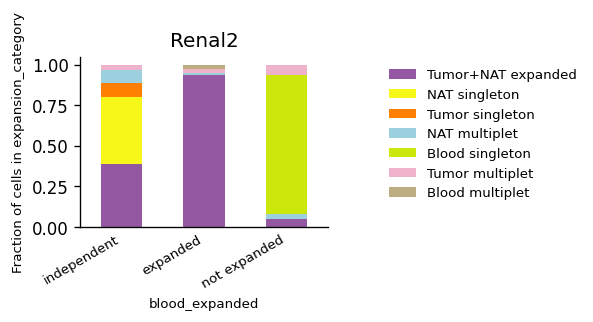

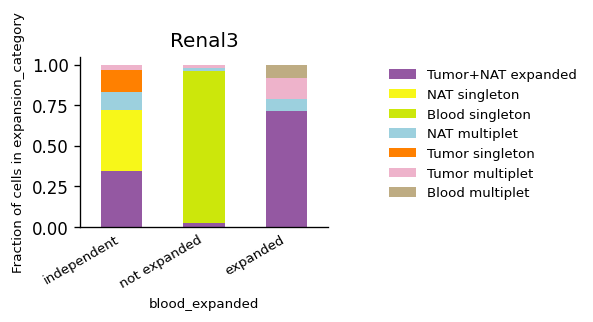

In [164]:
for patient in ["Lung6", "Renal1", "Renal2", "Renal3"]:
    ax = ir.pl.group_abundance(
        adata[adata.obs["patient"] == patient,:],
        groupby="blood_expanded", 
        target_col="expansion_category", 
        fraction=True)
    ax.set_title(patient)

Tissue expansion patterns of T cell by cluster. 

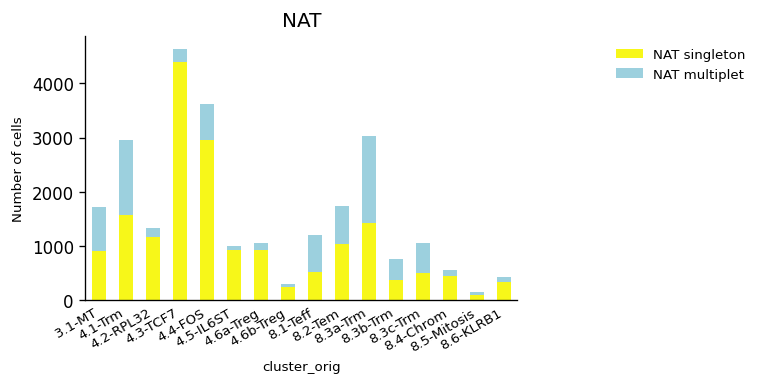

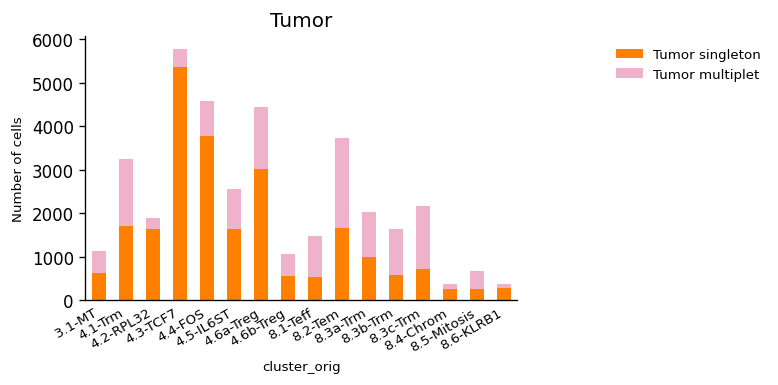

In [165]:
for subset in [["NAT singleton", "NAT multiplet"], ["Tumor singleton", "Tumor multiplet"]]:
    ax = ir.pl.group_abundance(
        adata[adata.obs["expansion_category"].isin(subset),:],
        groupby="cluster_orig", 
        target_col="expansion_category", 
        fraction=False,
        fig_kws={"dpi": 120},
        sort="alphabetical"
    )
    ax.set_title(subset[0].split()[0]) 

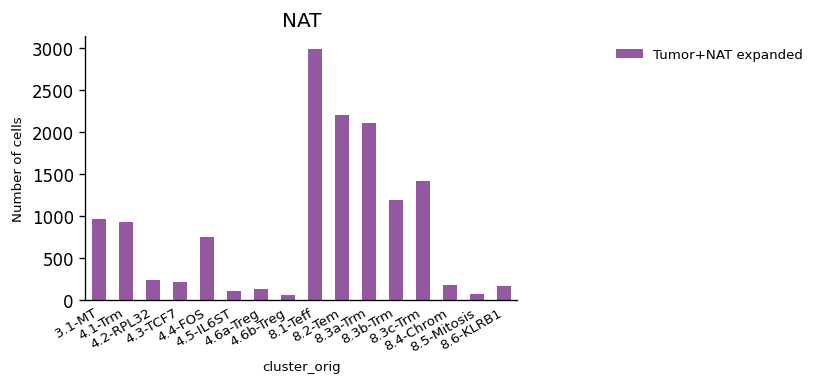

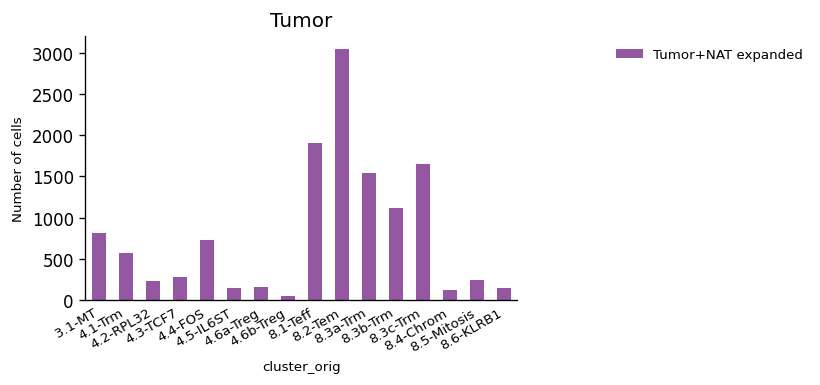

In [167]:
for source in ["NAT", "Tumor"]:
    ax = ir.pl.group_abundance(
        adata[(adata.obs["source"] == source) & (adata.obs["expansion_category"] == "Tumor+NAT expanded"),:],
        groupby="cluster_orig", 
        target_col="expansion_category", 
        fraction=False,
        fig_kws={"dpi": 120},
        sort="alphabetical"
    )
    ax.set_title(source)

## 6. Gene usage

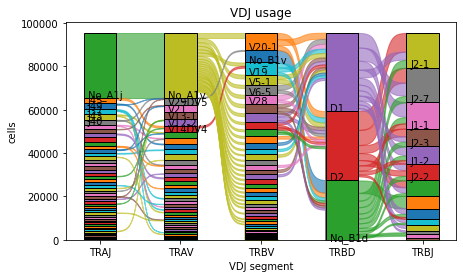

In [168]:
ax = ir.pl.vdj_usage(adata, full_combination=False, top_n=30)
ax.set_ylabel("cells")
ax.set_xlabel("VDJ segment")
ax.set_title("VDJ usage")
fig = ax.get_figure()
fig.savefig("figures/vdj_usage.svg")

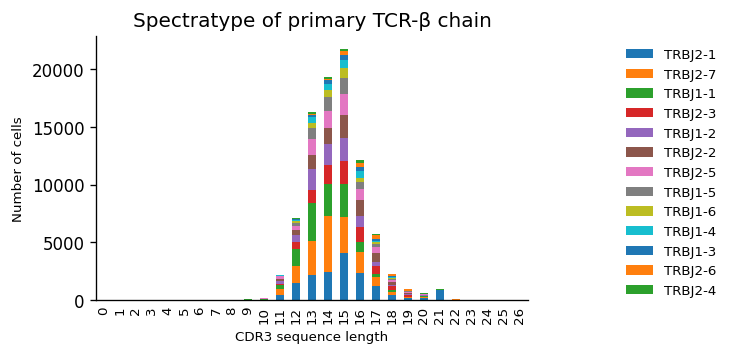

In [169]:
ax = ir.pl.spectratype(adata[adata.obs["TRB_1_j_gene"] != "None", :], groupby="TRB_1_cdr3", target_col="TRB_1_j_gene", fig_kws={"dpi": 120})
ax.xaxis.set_tick_params(rotation=90)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("center")
ax.set_title("Spectratype of primary TCR-β chain")
ax.set_xlabel("CDR3 sequence length")
fig = ax.get_figure()
fig.savefig("figures/spectratype.svg")